# __ACA dark current map__

In [28]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import pyyaks.logger
import numpy.ma as ma
import collections

In [29]:
#   For each image, pick out the 'X's
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  XXXXXXXX  |        X....X
#   |/ XX....XX  |/       X....X
#      XX....XX           X....X
#      XX....XX           X....X
#      XX....XX           .XXXX.
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

#r = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
#     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
#     2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]
#c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
#     0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 6, 7, 7, 7, 7]
#
#rin = [2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
#cin = [2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]

# OR
#
#    8x8                6x6
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->

r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]

rin = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]
cin = [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6,
       1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]

### Functions ###

In [30]:
class coords(object):
    rstart = 0
    rend = 0
    cstart = 0
    cend = 0

    def __init__(self, rstart, rend, cstart, cend):
        self.rstart = rstart
        self.rend = rend
        self.cstart = cstart
        self.cend = cend
        self.dr = rend - rstart
        self.dc = cend - cstart


def get_coords(slot_data, shift, img_size):
    # 'Absolute' (r, c) coordinates of the patch sampled by dither during a dwell
    # (1024x1024 pixel array)
    r1 = slot_data['IMGROW0'].min() + shift
    r2 = slot_data['IMGROW0'].max() + shift + img_size
    c1 = slot_data['IMGCOL0'].min() + shift
    c2 = slot_data['IMGCOL0'].max() + shift + img_size
    abs_coords = coords(r1, r2, c1, c2)
    return abs_coords


def get_frame_row(frame_data, img_size): # frame_data = current row in Table(slot_data)
    
    # frame_row is a dict that combines current slot_data such as
    # IMGROW0, IMGCOL0, IMGRAW, BGDAVG, and a dict of edge pixel vals
    frame_row = collections.OrderedDict()
    
    row0 = frame_data['IMGROW0'][0]
    col0 = frame_data['IMGCOL0'][0]
    raw_image = frame_data['IMGRAW'][0]
    
    # Pick out the edge pixels
    frame_row['edge_vals'] = edge_pixels_dict_8x8(raw_image, row0, col0)
        
    frame_row['row0'] = row0
    frame_row['col0'] = col0
    frame_row['raw_img'] = raw_image
    frame_row['bgdavg'] = frame_data['BGDAVG'][0]

    return frame_row


def edge_pixels_dict_8x8(raw_image, row0, col0):

    edge_pixels_dict = collections.OrderedDict()
    
    raw_image = raw_image.reshape(8, 8, order='F')
    
    for rr, cc in zip(r, c): # (r, c) define location of edge pixels (X's)
        r_abs = row0 + rr + shift
        c_abs = col0 + cc + shift
        key = '{}.{}'.format(r_abs, c_abs) # e.g. '781.428'
        edge_pixels_dict[key] = raw_image[rr, cc]
        
    return edge_pixels_dict


def update_deque_dict(abs_coords, deque_dict, frame_row):
    # Consider pixels sampled by dither, with
    # r = (abs_coords.rstart:abs_coords.rend) and c = (abs_coords.cstart:abs_coords.cend)
    #
    # Update deque_dict:
    # 1. extend deque with edge value if we are on the edge
    # 2. extend deque with bgdavg if we are 'inside'? No, do nothing
    #        NO, because if img drifts enough to include an edge hot pixel 'inside',
    #        then the info that this is a hot pixel is lost if we start including bgdavg
    #        vals in the deque
    # 3. init 'outside' pixels with an empty deque (same for 'inside' pixels, see above)
    # 4. if > ndeque elements in a deque, pop the first one
    
    for rr in range(abs_coords.rstart, abs_coords.rend):
        for cc in range(abs_coords.cstart, abs_coords.cend):
            key = '{}.{}'.format(rr, cc)
            inside = get_location(rr, cc, frame_row['row0'], frame_row['col0'], loc=1)
            edge = get_location(rr, cc, frame_row['row0'], frame_row['col0'], loc=0)
                       
            if key in deque_dict.keys():                    
                if edge:
                    deque_dict[key].extend([frame_row['edge_vals'][key]])
                #elif inside: # do nothing
                #else: # outside, do nothing
                
                # Keep the length at ndeque
                if len(deque_dict[key]) > ndeque:
                    deque_dict[key].pop()

            elif key not in deque_dict.keys(): # happens 1st time only, initialization
                if edge: # init with edge val
                    deque_dict[key] = collections.deque([frame_row['edge_vals'][key]])                   
                elif inside: # init with empty
                    deque_dict[key] = collections.deque([])
                else: # outside, init with empty
                    deque_dict[key] = collections.deque([])

            # Testing:
            #if key in deque_dict.keys():
            #    test_1(key, abs_coords, deque_dict, frame_row)
            
    return deque_dict


def get_location(rr, cc, row0, col0, loc=0):
    # For now this works only for 8x8
    # rr, cc are absolute coordinates (0:1023) of pixels in the sampled patch
    r_abs = r + (row0 + shift) * np.ones(len(r))
    c_abs = c + (col0 + shift) * np.ones(len(c))
    rin_abs = rin + (row0 + shift) * np.ones(len(rin))
    cin_abs = cin + (col0 + shift) * np.ones(len(cin))
    if loc > 0: # test for inside
        location = (rr, cc) in zip(rin_abs, cin_abs)
    elif loc == 0: # test for edge
        location = (rr, cc) in zip(r_abs, c_abs)
    else: # < 0, test for outside
        location = (rr, cc) not in zip(rin_abs, cin_abs) and (rr, cc) not in zip(r_abs, c_abs)
    return location


def background(abs_coords, current_row0, current_col0, img_size, median_dict):
    
    # Find the 8x8 window corresponding to the current frame
    rstart = current_row0 - (abs_coords.rstart - shift) # current ROW0 - ROW0.min
    cstart = current_col0 - (abs_coords.cstart - shift) # current COL0 - COL0.min

    rend = rstart + img_size
    cend = cstart + img_size

    bgd_img = np.array(median_dict.values()).reshape(abs_coords.dr, abs_coords.dc)    
    
    bgd_img = bgd_img[rstart:rend]    
    
    bgd_img = bgd_img.T[cstart:cend].T

    return bgd_img


# img_size = 6 science observation (this may not work in case of slots with FIDs)
# img_size = 8 ER observation
# img_mask = None for science observations
def get_current_centroids(img, img_size):
    
    if img_size not in [6, 8]:
        raise Exception("Image size outside of allowed values [6, 8] (6x6 or 8x8)")
        
    num = np.arange(0.5, 6.5)

    #How relevant is this?
    if (img_size == 8):
        img = zero_6x6_corners(img, centered=True)
    else:
        img = zero_6x6_corners(img, centered=False)
    
    centroids = []
    for ax in [0, 1]:
        # Def of flat is where img_mask becomes relevant for ER data and comparison with telemetry
        flat = np.sum(img, axis=ax)
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2])  # 0:6
        else:
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1]) + 1  # 1:7, is +1 relevant?
        centroids.append(centroid)
        
    return centroids


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if len(img) != 8 or len(img.shape) != 2:
        raise Exception("Img should be a 8x8 array")
    if centered:
        r = [1, 1, 6, 6]
        c = [1, 6, 1, 6]
    else:
        r = [0, 0, 5, 5]
        c = [0, 5, 0, 5]
    for rr, cc in zip(r, c):
        img[rr][cc] = 0.0
    return img


# In 8x8 img, mask the edge pixels, leave r/c 1:7 unmasked.
# For science observations the raw image is masked by default (r/c 0:6 are left unmasked).
def get_mask_8x8_centered():
    m = """\
        1 1 1 1 1 1 1 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1"""
    mask = np.array([line.split() for line in m.splitlines()], dtype=float)
    return mask

In [31]:
def get_centroids(slot_data, img_size, bgd=bgd):
    # Calls:
    #     get_coords
    #     get_frame_row
    #     update_deque_dict
    #     background
    #     get_current_centroids
    #
    
    if bgd not in ['bgdavg', 'dark_current', 'mixed']:
        raise Exception("get_centroids:: bgd should be one of bgdavg, dark_current, mixed")
    
    nn = len(slot_data)
    #nn = 30 # for testing decrease the number of processed frames
        
    abs_coords = get_coords(slot_data, shift, img_size)
    
    deque_dict = collections.OrderedDict()
    median_dict= collections.OrderedDict()
    
    yagzag_centroids = []
    yagzag_centroids_compare = []

    for index in range(0, nn):
        
        frame_data = slot_data[index:index + 1]
        frame_row = get_frame_row(frame_data, img_size)
        
        # Background subtraction for the current 8x8 image
        # 1. Cycle through all patch pixels
        # 2. Compute median for each deque with at least one element
        # 3. Use 0. for pixels with empty deques (were always 'outside' until now)
        # 4. Populate median_dict. Depending on 'bgd' argument:
        #        - 'bgdavg': use avg background (current algorithm)
        #        - 'dark_current': use median for pixels sampled by dither, nothing for unsampled pixels
        #        - 'mixed': use avg background for pixels not in the deque, and
        #                    median for pixels sampled by dither
        # 5. Treat median_dict as a background map, subtract from the raw_image

        if bgd in ['dark_current', 'mixed']:
            deque_dict = update_deque_dict(abs_coords, deque_dict, frame_row)
        
            for key in deque_dict.keys():
                if len(deque_dict[key]) > 0:
                    median_dict[key] = np.median(deque_dict[key])
                else:
                    # I do this so that I have a median_dict value for each patch pixel and
                    # can reshape the median_dict in background() so that it matches dr, dc
                    # dimensions of the patch sampled by dither
                    #
                    # bgd subtraction is done only for the 8x8 current image pixels
                    # and there will always be at least one value for each of them
                    coords = key.split('.', 1)
                    inside = get_location(np.int(coords[0]), np.int(coords[1]),
                                          frame_row['row0'], frame_row['col0'], loc=1)
                    if inside:
                        if bgd == 'mixed':
                            median_dict[key] = frame_row['bgdavg']
                        if bgd == 'dark_current':
                            median_dict[key] = 0.0                            
                    else: # outside, can't be edge if len(deque_dict[key]) = 0
                        median_dict[key] = 0.0

            # Test:
            #test_2(index, abs_coords, deque_dict, median_dict, frame_row)

            # Find the relevant 8x8 section of median_dict and use as bgd_img
            bgd_img = background(abs_coords, frame_row['row0'], frame_row['col0'],
                                 img_size, median_dict)

        else:
            bgd_img = frame_row['bgdavg'] * np.ones((8, 8))
            
        raw_img = frame_row['raw_img']
        raw_img = raw_img.reshape(8, 8, order='F')
                    
        # Subtract background img and mask the edge before computing
        # first moments using the 6x6 modified (?) pixels
        img = raw_img - bgd_img
        img = ma.array(img, mask=img_mask)
        
        #print 'Raw image: ', raw_img
        #print 'Bgd image: ', bgd_img
        #print 'Image: ', img
                        
        # Calculate centroids for current bgd subtracted img, use first moments
        centroids = get_current_centroids(img, img_size)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = centroids[0] + frame_row['row0'] # do not add shift
        z_pixel = centroids[1] + frame_row['col0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)

        yagzag_centroids.append(yagzag)
                                   
    return yagzag_centroids

In [32]:
def centroids(slots, img_size, bgd='mixed'):
   
    rows = []

    for slot in slots:
        print 'Slot = {}'.format(slot)
        slot_row = {'slot':slot, 'row0':[], 'col0':[], 'yan_raw':[], 'zan_raw':[]}
    
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        
        cntrds = get_centroids(slot_data, img_size, bgd=bgd)

        slot_data = Table(slot_data)
        time = slot_data['TIME']
        
        slot_row['time'] = time
        slot_row['row0'] = slot_data['IMGROW0']
        slot_row['col0'] = slot_data['IMGCOL0']
        
        raw_yagzag = np.array(cntrds).T # [0] - yag, [1] - zag
    
        slot_row['yan_raw'].append(raw_yagzag[0])
        slot_row['zan_raw'].append(raw_yagzag[1])

        rows.append(slot_row)
    
    return rows

In [33]:
# Plotting functions

def plot_d_ang(key, dt, t1, t2=None):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    if t2 is None:
        t2 = t1
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t2[key][slot][0], t2['time'][slot] + dt[i],
                                           t1['time'][2],
                                           method="nearest")
        d_ang = t1[key][2][0] - ang_interp
        plt.plot(t1['time'][2], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.plot(t1['time'][2], t1['row0'][2], color='y')
        plt.plot(t1['time'][2], t1['row0'][slot], color='darkorange')
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return

### Computations ###

In [34]:
# 50804, stars in all slots tracked, star in slot 7 faint, all other stars bright
obsid = 50804
img_mask = get_mask_8x8_centered()
dwell = events.dwells.filter(obsid=obsid)[0]

In [35]:
img_size = 8
slots = range(8)
shift = 512 # so that we end up with coordinates in the 0:1023 range
ndeque = 5 # number of vals kept in each deque

In [36]:
# bgd:
#    bgdavg - subtract average background (current algorithm)
#    dark_current - subtract only dark current (median), for pixels not on the list do nothing
#    mixed - subtract dark current (median), for pixels not on the list use current avg bgd

In [37]:
bgd = 'bgdavg'
rows_ba = centroids(slots, img_size, bgd=bgd)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [38]:
bgd = 'dark_current'
rows_dc = centroids(slots, img_size, bgd=bgd)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [39]:
bgd = 'mixed'
rows_m = centroids(slots, img_size, bgd=bgd)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [40]:
t_ba = Table(rows_ba)
t_dc = Table(rows_dc)
t_m = Table(rows_m)

In [41]:
print t_ba.colnames

['col0', 'mean_mags', 'row0', 'slot', 'time', 'yan_raw', 'zan_raw']


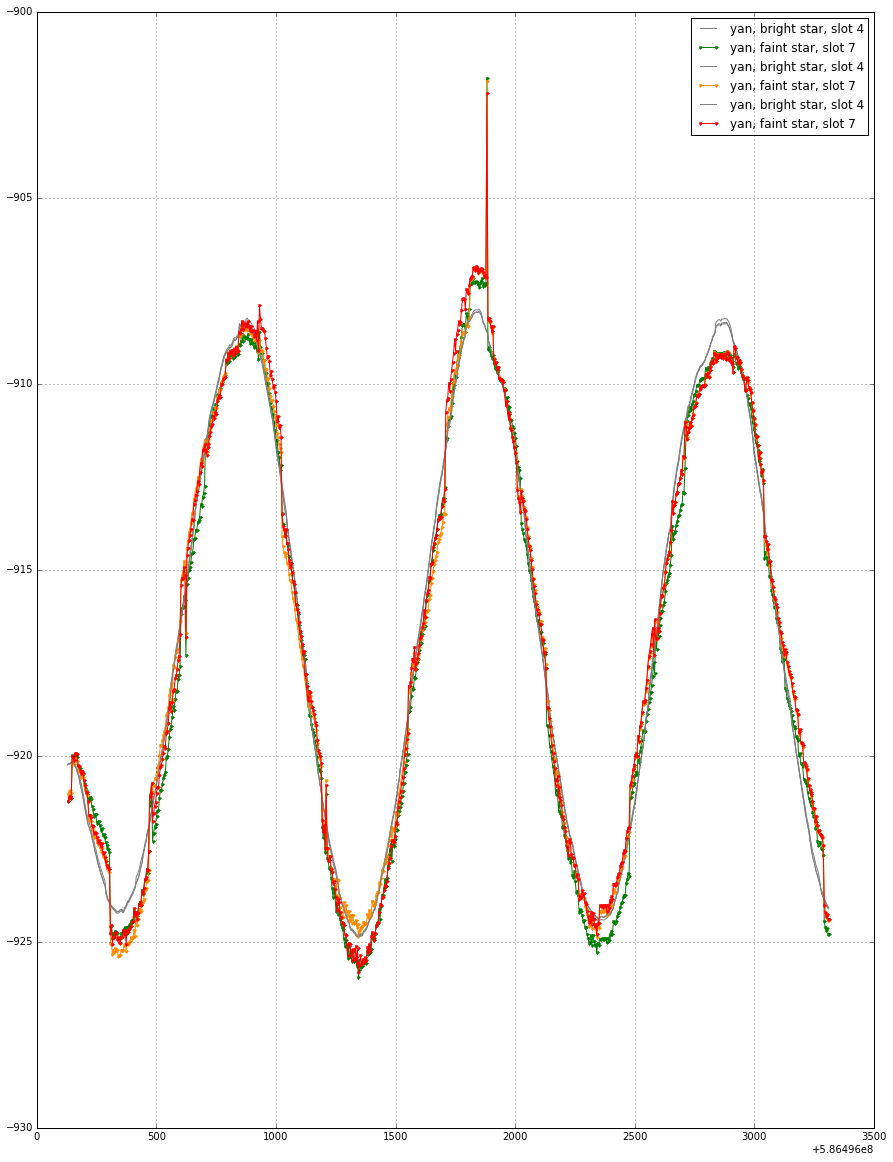

In [44]:
fig = plt.figure(figsize=(15, 20))
color = ['green', 'darkorange', 'red']
for i, t in enumerate([t_ba, t_dc, t_m]):
    plt.plot(t['time'][4], t['yan_raw'][4][0] - 2198, color='gray',  label='yan, bright star, slot 4')
    plt.plot(t['time'][7], t['yan_raw'][7][0], color=color[i], marker='.', label='yan, faint star, slot 7')
plt.grid()
plt.legend()

In [30]:
print [(t_ba['time'][2] - t_ba['time'][slot])[:3] for slot in slots]

[array([-2.05000019, -2.04999995, -2.05000019]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([ 0.,  0.,  0.]), array([-2.05000019, -2.04999995, -2.05000019]), array([-2.05000019, -2.04999995, -2.05000019]), array([-2.05000019, -2.04999995, -2.05000019])]


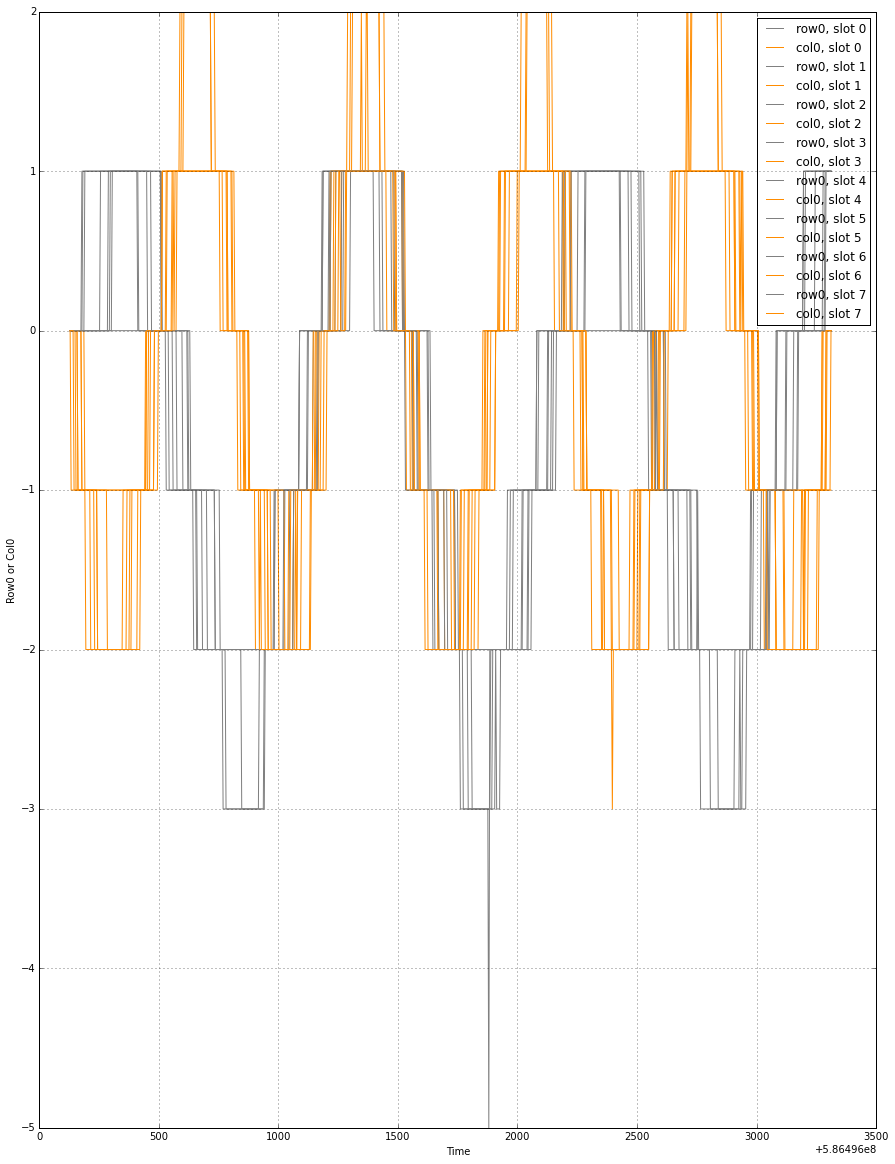

In [46]:
dt = [-2.05, 0, 0, 0, 0, -2.05, -2.05, -2.05]
fig = plt.figure(figsize=(15, 20))
for slot in slots:
    plt.plot(t_m['time'][slot] + dt[slot], t_m['row0'][slot] - t_m['row0'][slot][0],
             color='gray', label='row0, slot {}'.format(slot))
    plt.plot(t_m['time'][slot] + dt[slot], t_m['col0'][slot] - t_m['col0'][slot][0],
             color='darkorange', label='col0, slot {}'.format(slot))
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Row0 or Col0")

Method: average background subtraction


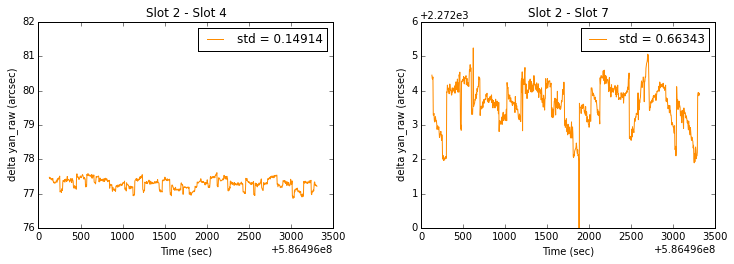

In [47]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_ba)
print "Method: average background subtraction"

Method: dark current map subtraction


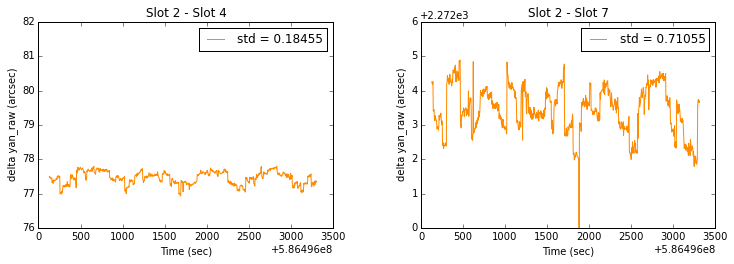

In [48]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_dc)
print "Method: dark current map subtraction"

Method: mixed map subtraction


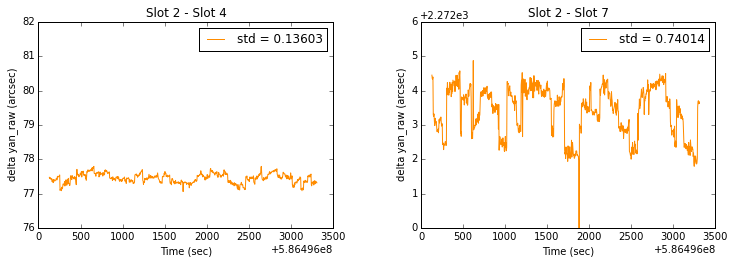

In [49]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_m)
print "Method: mixed map subtraction"

### Tests ###

__Row and Col coordinates__

In [ ]:
# Definition of (r, c) coordinates

slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
raw_image = slot_data['IMGRAW'][0]

print 'Raw image:'
print raw_image
print
print "Raw image (reshaped):"
print raw_image.reshape(8, 8, order='F')
print
print "Edge pixels:"
for rr, cc in zip(r, c):
    print "(r, c) = ({}, {}): {}".format(rr, cc, raw_image.reshape(8, 8, order='F')[rr, cc])

 __edge_pixels_dict_8x8__

In [ ]:
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=3)
frame_data = slot_data[7:8]

raw_image = frame_data['IMGRAW'][0]
row0 = frame_data['IMGROW0'][0]
col0 = frame_data['IMGCOL0'][0]

edge_pixels_dict = edge_pixels_dict_8x8(raw_image, row0, col0)

print "Raw image (reshaped):"
print raw_image.reshape(8, 8, order='F')
print
print "Row0, Col0 = {}, {}".format(row0, col0)
print
rr = row0 + shift
cc = col0 + shift
print "Row, Col in 1024x1024 = {}, {}".format(rr, cc)
print
print "edge_pixels_dict:"
print edge_pixels_dict
print
print "Verify some edge values:"
print
print "Upper left = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc)])
print "Upper right = {}".format(edge_pixels_dict['{}.{}'.format(rr, cc + 7)])
print "Lower left = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc)])
print "Lower right = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 7)])
print "Row 2, Col 0 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 2, cc)])
print "Row 7, Col 6 = {}".format(edge_pixels_dict['{}.{}'.format(rr + 7, cc + 6)])

In [ ]:
def test_1(key, coords, deque_dict, frame_row):
    print "T1: Key = ", key
    print "T1: Frame edge keys = ", frame_row['edge_vals'].keys()
    print "T1: Frame row0, col0 shifted = ", frame_row['row0'] + shift, frame_row['col0'] + shift
    print "T1: dict_deque[key] = ", deque_dict[key]
    print
    return


def test_2(ii, coords, deque_dict, median_dict, frame_row):
    print 'T2: Index = {}'.format(ii)
    print 'T2: Deque_dict size = {}'.format(len(deque_dict))
    for r in range(coords.rstart, coords.rend):
        keys = ['{}.{}'.format(r, cc) for cc in range(coords.cstart, coords.cend)]
        print 'T2: Keys: '
        print keys
        print "T2: Deque_dict:"
        vals = [deque_dict[key] for key in keys]
        print vals
        print "T2: Median_dict:"
        vals = [median_dict[key] for key in keys]
        print vals
        print
    
    # Reshape median_dict
    print "T2: Median reshaped:"
    print np.array(median_dict.values()).reshape(coords.dr, coords.dc)
    return